<a href="https://colab.research.google.com/github/staller84/minhee/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget -O amazon_reviews.zip https://www.dropbox.com/sh/ejslwuc740kv30l/AAAL21BDqjlNaZ7MDfR6xY9ja?dl=0 
!unzip /content/amazon_reviews.zip

--2019-11-29 10:33:09--  https://www.dropbox.com/sh/ejslwuc740kv30l/AAAL21BDqjlNaZ7MDfR6xY9ja?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/ejslwuc740kv30l/AAAL21BDqjlNaZ7MDfR6xY9ja [following]
--2019-11-29 10:33:10--  https://www.dropbox.com/sh/raw/ejslwuc740kv30l/AAAL21BDqjlNaZ7MDfR6xY9ja
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdce3baf096d28b48030a7008db.dl.dropboxusercontent.com/zip_by_token_key?key=AtSphSfUc2EZ8qq4ueEtUAw7OdQepXRarPLQkzRB-bnkbFSmuNnkhfAyvmFaYILBFheHhcFJIoDaqirzSv41QdeLBMfh_AGQiM1XJvnaJgnsI_8OvWtNKUZmOrgmmQWuaIfbhBmcY0zxNm93WKG3njqe9DziCdG9OcuwUMNoIDswEpM4AGDys-FVj3stRXI2XZhMVOiJy_4qjATum_pM9xmqJGUtxI1KGfDS3Rqm6YFLkQ [following]
--2019-11-29 10:33:10--  https://ucdce3baf096d28b48030

In [0]:
import os
import numpy as np
import nltk
import random
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

nltk.download('punkt')

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# 학습 데이터와 평가 데이터
- Train_data와 Test_data를 읽고 몇 개의 예를 출력해 봅니다.
- Label의 경우 부정 : 0, 긍정 1로 설정합니다.

In [0]:
def read_dataset(dataset_type):
  max_seq_len = 0
  with open("/content/%s.txt" % dataset_type, "r", encoding="utf-8") as fr_handle:
    labels, sentences, tokenized_sentences = [], [], []
    for line in fr_handle:
      if line.strip() == 0:
        continue
      label = line.split(' ')[0]
      label = 0 if label == "__label__1" else 1 # 부정이면 0, 긍정이면 1

      sentence = ' '.join(line.split(' ')[1:])
      tokenized_sentence = nltk.word_tokenize(sentence)
      max_seq_len = max(max_seq_len, len(tokenized_sentence))

      labels.append(label)
      sentences.append(sentence)
    
    return labels, sentences, max_seq_len

TRAIN_LABELS, TRAIN_SENTENCES, TRAIN_MAX_SEQ_LEN = read_dataset("train")
TEST_LABELS, TEST_SENTENCES, TEST_MAX_SEQ_LEN = read_dataset("test")
MAX_SEQUENCE_LEN = max(TRAIN_MAX_SEQ_LEN, TEST_MAX_SEQ_LEN)

print("Train : ", len(TRAIN_SENTENCES))
for train_label, train_sent in zip(TRAIN_LABELS, TRAIN_SENTENCES[0:10]):
  print(train_label, ':' ,train_sent)

print()
print("Test : ", len(TEST_SENTENCES))
for test_label, test_sent in zip(TEST_LABELS, TEST_SENTENCES[0:10]):
  print(test_label, ':' ,test_sent)

print("MAX_SEQUENCE_LEN", MAX_SEQUENCE_LEN)
with open("/content/vocab.txt", "r", encoding="utf-8") as vocab_handle:
  VOCAB = [line.strip() for line in vocab_handle if len(line.strip()) > 0]
  
  print("Total vocabulary", VOCAB)

Train :  18000
0 : Do Note Buy - Cheap Product: I purchased this in early March 2011 on Amazon. What I received in the mail a week later was Ross Deer Netting, which is very different than what is listed here and sells for only $18 on Amazon. I received a full refund, but frustrating to buy a product and get something totally different. Amazon's sticker on the product even said it was Easy Gardner Deer Fencing. Very misleading. Do Not Buy this from Amazon!!!

0 : Non-Functioning Display: After only 3 weeks, one of the led's in the display has quit working and a second keeps slowly fading in and out, so I am sure it will quit working before long. I am very disappointed in the quality of this product. Unfortunately, I don't have the time or the paperwork to return it, so I am stuck with a semi-functioning display.I do like the design and the small footprint on my desk. But, if it doesn't work properly, a good design is useless.

0 : The scissors work fine but...: I received these from my

# Keras를 통한 전처리 과정
1) Text를 tokenize하여 id 값으로 변경해 줍니다. (tokenizer.texts_to_sequences)  
2) id로 변경해준 문장들을 모두 문장 최대 길이로 padding 처리해 줍니다. (pad_sequences)

In [0]:
tokenizer = Tokenizer(num_words=len(VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(TRAIN_SENTENCES)
TRAIN_SEQUENCES = tokenizer.texts_to_sequences(TRAIN_SENTENCES)
TEST_SEQUENCES = tokenizer.texts_to_sequences(TEST_SENTENCES)
VOCAB_SIZE = len(tokenizer.word_index) + 1

print(TRAIN_SENTENCES[2])
print(TRAIN_SEQUENCES[2])

The scissors work fine but...: I received these from my Aunt who purchased them and was disappointed with them and when I said it was a cool concept she let me have them. The scissors themselves work like you would expect from your run of the mill scissors however the laser guide is just gimmicky. The problem with the laser guidance system is that if you turn the scissors slightly the line moves with it so it serves absolutely no purpose. For that reason alone I could not give this a good score however I gave it one extra then the 1 star the laser guidance system would warrant because the scissor portion is perfectly functional.

[1, 6072, 96, 301, 16, 2, 290, 75, 35, 20, 6393, 74, 229, 68, 3, 13, 206, 17, 68, 3, 49, 2, 269, 6, 13, 4, 463, 1061, 107, 341, 43, 21, 68, 1, 6072, 1028, 96, 32, 15, 38, 580, 35, 58, 552, 7, 1, 3651, 6072, 177, 1, 3652, 626, 9, 36, 17960, 1, 235, 17, 1, 3652, 4533, 518, 9, 12, 28, 15, 482, 1, 6072, 1199, 1, 364, 1312, 17, 6, 26, 6, 3558, 444, 48, 1313, 11, 12

In [0]:
X_train = pad_sequences(TRAIN_SEQUENCES, padding='post', maxlen=MAX_SEQUENCE_LEN)
X_test = pad_sequences(TEST_SEQUENCES, padding='post', maxlen=MAX_SEQUENCE_LEN)
print("PAD_SEQUENCES COMPLETES")
print(X_train[0])
print(MAX_SEQUENCE_LEN)

PAD_SEQUENCES COMPLETES
[   65   879    84   352    81     2   229     8    10   694  4132  4872
    18   173    44     2   290    10     1  1214     4   501   542    13
  7636  5773 24791    90     9    29   211    71    44     9  1323   197
     3  3556    11    57  1376    18   173     2   290     4   327   919
    16  1503     5    84     4    81     3    47   156   512   211  2898
  5032    18     1    81    70   269     6    13   166 10852  5773 17959
    29  1359    65    14    84     8    35   173     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0   

# 모델 설정
- Random으로 초기화된 임베딩이 아닌 pre-trained 된 GLoVE 임베딩으로 학습하고자 합니다.  
- 따라서 학습 코퍼스에 있는 단어들 중 GLoVE 임베딩에 있는 단어들을 GLoVE 임베딩으로 초기화 해줍니다.  
- 본 실험에서는 GLoVE 임베딩 크기가 50인 것과 100인 것을 통해 실험을 진행해 봅니다.

In [0]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

EMBEDDING_DIM = 50 #100
embedding_matrix = create_embedding_matrix(
    '/content/glove.6B.50d.txt',
    tokenizer.word_index, EMBEDDING_DIM)

# 실험을 진행한 후 Accuracy와 Loss를 시각화하기 위한 함수입니다.

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

<img src="https://github.com/taesunwhang/sentiment_analysis_tutorial/blob/master/resources/cnn_model_sentiment%20analysis.gif?raw=true">


1) CNN 모델 
- Word Embedding Layer가 모델 학습 시 학습이 되지 않습니다.
- Convolution 필터의 경우 Window Size가 3인 필터가 100개 학습됩니다.

In [0]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(VOCAB_SIZE, 
                           EMBEDDING_DIM, 
                           weights=[embedding_matrix], 
                           input_length=MAX_SEQUENCE_LEN, 
                           trainable=False)) # False

model.add(layers.Conv1D(filters=100,
                        kernel_size=3, 
                        activation='relu',
                        padding='valid'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 273, 50)           2476650   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 271, 100)          15100     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 2,492,771
Trainable params: 16,121
Non-trainable params: 2,476,650
_______________________________________

이제 학습을 위한 준비가 모두 끝났습니다!  
모델의 학습은 *model.fit*을 통해 진행되며, 본 실험에서는 epoch 10번에 대해 실험을 진행합니다.   
매 에폭마다 Testset을 통해 Evaluation을 진행합니다.

In [0]:
history = model.fit(X_train, TRAIN_LABELS,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, TEST_LABELS),
                    batch_size=128)



Train on 18000 samples, validate on 2000 samples
Epoch 1/10
18000/18000 [==============================] - 13s 707us/step - loss: 0.6377 - acc: 0.6356 - val_loss: 0.5334 - val_acc: 0.7450
Epoch 2/10
18000/18000 [==============================] - 12s 670us/step - loss: 0.4981 - acc: 0.7608 - val_loss: 0.4480 - val_acc: 0.7945
Epoch 3/10
18000/18000 [==============================] - 12s 671us/step - loss: 0.4395 - acc: 0.7944 - val_loss: 0.4142 - val_acc: 0.8185
Epoch 4/10
18000/18000 [==============================] - 12s 664us/step - loss: 0.4107 - acc: 0.8117 - val_loss: 0.4013 - val_acc: 0.8220
Epoch 5/10
18000/18000 [==============================] - 12s 667us/step - loss: 0.3897 - acc: 0.8238 - val_loss: 0.3930 - val_acc: 0.8255
Epoch 6/10
18000/18000 [==============================] - 12s 672us/step - loss: 0.3715 - acc: 0.8337 - val_loss: 0.3924 - val_acc: 0.8250
Epoch 7/10
18000/18000 [==============================] - 12s 666us/step - loss: 0.3577 - acc: 0.8399 - val_loss: 0

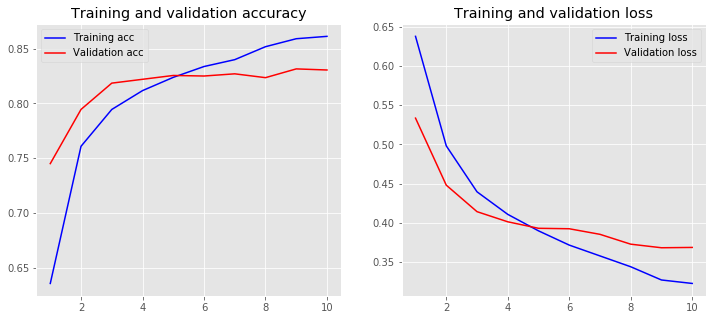

In [0]:
plot_history(history)

2) CNN 모델
- Word Embedding Layer가 모델 학습 시 학습이 됩니다. 따라서 학습 소요 시간이 더 길어집니다.
- Pre-trained 임베딩을 사용해 Embedding Layer를 초기화하고, 이 임베딩을 CNN 모델 학습 시 함께 학습한다면 성능이 더 올라갈까요?
- 정답은 "올라갑니다." 입니다. 이유는 사전에 GLoVE가 학습했던 코퍼스는 General한 코퍼스이고, 저희가 CNN 모델 학습 시 사용하는 데이터는 리뷰 데이터로 분명한 차이가 존재합니다.
- 임베딩을 모델 학습 시 함께 학습한다면 단어 임베딩이 코퍼스에 알맞게 Fine-tuning 되기 때문에 보다 리뷰 데이터를 잘 학습할 수 있게 됩니다.
- Convolution 필터의 경우 Window Size가 3인 필터 100개가 학습됩니다.

In [0]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Embedding(VOCAB_SIZE, 
                           EMBEDDING_DIM, 
                           weights=[embedding_matrix], 
                           input_length=MAX_SEQUENCE_LEN, 
                           trainable=True)) # True

model.add(layers.Conv1D(filters=100, 
                        kernel_size=3, 
                        activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 273, 50)           2476650   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 271, 100)          15100     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 2,492,771
Trainable params: 2,492,771
Non-trainable params: 0
____________________________________________

In [0]:
history = model.fit(X_train, TRAIN_LABELS,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, TEST_LABELS),
                    batch_size=128)

Train on 18000 samples, validate on 2000 samples
Epoch 1/10
18000/18000 [==============================] - 19s 1ms/step - loss: 0.6586 - acc: 0.6124 - val_loss: 0.5264 - val_acc: 0.7445
Epoch 2/10
18000/18000 [==============================] - 18s 1ms/step - loss: 0.4539 - acc: 0.7874 - val_loss: 0.3718 - val_acc: 0.8425
Epoch 3/10
18000/18000 [==============================] - 18s 1ms/step - loss: 0.3341 - acc: 0.8548 - val_loss: 0.3314 - val_acc: 0.8525
Epoch 4/10
18000/18000 [==============================] - 18s 1ms/step - loss: 0.2710 - acc: 0.8905 - val_loss: 0.3232 - val_acc: 0.8605
Epoch 5/10
18000/18000 [==============================] - 18s 1ms/step - loss: 0.2146 - acc: 0.9168 - val_loss: 0.3286 - val_acc: 0.8660
Epoch 6/10
18000/18000 [==============================] - 18s 1ms/step - loss: 0.1667 - acc: 0.9392 - val_loss: 0.3269 - val_acc: 0.8670
Epoch 7/10
18000/18000 [==============================] - 18s 1ms/step - loss: 0.1268 - acc: 0.9570 - val_loss: 0.3398 - val_acc:

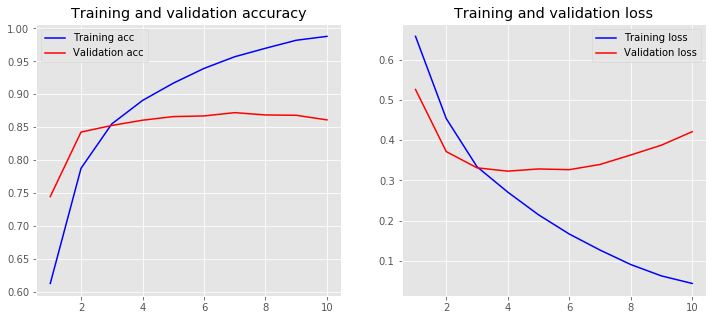

In [0]:
plot_history(history)

3) CNN모델 - Multiple Filters
- 지금까지는 CNN 모델 학습 시 Window Size가 3인 필터만 사용하여 학습을 시켰습니다.
- 그렇다면 Convolution 필터를 앞서 배운 것처럼 여러 개를 사용해 볼까요?
- 본 모델은 필터의 Window Size가 2, 3, 4, 5인 필터 각 100개씩을 사용해 모델을 학습합니다.
- 다양한 크기의 필터를 사용하면 성능이 더 올라갈까요?
- 정답은 "올라갑니다." 입니다. Convolution 필터가 보는 단어의 갯수가 다양하게 되기 때문에 문장의 local 정보와 global 정보 모두를 학습할 수 있게 됩니다.
- 그럼 실험을 통해 확인해 볼까요?

In [0]:
from keras.models import Sequential
from keras import layers
from keras.models import Model

seq_input = layers.Input(shape=(MAX_SEQUENCE_LEN,), dtype='int32')
seq_embedded = layers.Embedding(VOCAB_SIZE, 
                           EMBEDDING_DIM, 
                           weights=[embedding_matrix], 
                           input_length=MAX_SEQUENCE_LEN, 
                           trainable=True)(seq_input)

filters = [2,3,4,5]
conv_models = []
for filter in filters:
  conv_feat = layers.Conv1D(filters=100, 
                            kernel_size=filter, 
                            activation='relu',
                            padding='valid')(seq_embedded)
  pooled_feat = layers.GlobalMaxPooling1D()(conv_feat)
  conv_models.append(pooled_feat)

conv_merged = layers.concatenate(conv_models, axis=1)

model_output = layers.Dropout(0.2)(conv_merged)
model_output = layers.Dense(10, activation='relu')(model_output)
logits = layers.Dense(1, activation='sigmoid')(model_output)

model = Model(seq_input, logits)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 273)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 273, 50)      2476650     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 272, 100)     10100       embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 271, 100)     15100       embedding_4[0][0]                
____________________________________________________________________________________________

In [0]:
history = model.fit(X_train, TRAIN_LABELS,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, TEST_LABELS),
                    batch_size=128)

Train on 18000 samples, validate on 2000 samples
Epoch 1/10
18000/18000 [==============================] - 64s 4ms/step - loss: 0.5771 - acc: 0.6876 - val_loss: 0.4277 - val_acc: 0.8035
Epoch 2/10
18000/18000 [==============================] - 63s 4ms/step - loss: 0.3605 - acc: 0.8427 - val_loss: 0.3282 - val_acc: 0.8595
Epoch 3/10
18000/18000 [==============================] - 63s 4ms/step - loss: 0.2667 - acc: 0.8900 - val_loss: 0.3020 - val_acc: 0.8685
Epoch 4/10
18000/18000 [==============================] - 63s 4ms/step - loss: 0.2020 - acc: 0.9217 - val_loss: 0.3082 - val_acc: 0.8680
Epoch 5/10
18000/18000 [==============================] - 63s 4ms/step - loss: 0.1492 - acc: 0.9460 - val_loss: 0.3059 - val_acc: 0.8755
Epoch 6/10
17024/18000 [===========================>..] - ETA: 3s - loss: 0.1014 - acc: 0.9679

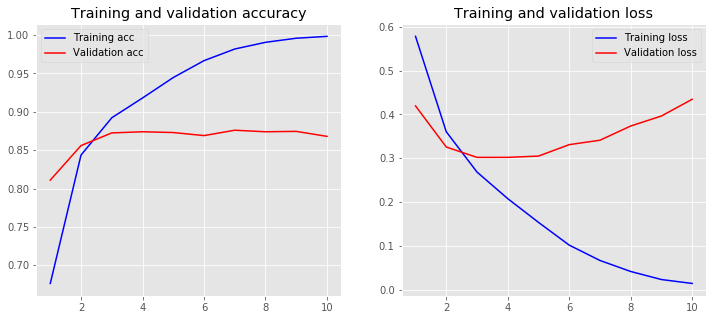

In [0]:
plot_history(history)

4) Bi-LSTM 모델
- 앞서 진행했던 두 개의 실험은 모두 CNN이었습니다.  
- 이번에는 지난 시간에 실습을 진행했던 Bi-LSTM을 통해 실험을 해봅시다.  
- Bi-LSTM을 사용한 모델은 문장 단위 자질을 다음과 같이 만들어 냅니다.  
[Forward LSTM의 가장 마지막 단어의 출력, Backward LSTM의 가장 마지막 단어의 출력]  
즉, 문장의 가장 마지막 단어의 Forward 출력과 문장의 가장 첫번째 단어의 Backward 출력을 Concatenation 합니다.
- 현재 아마존 리뷰 문장 분류에서는 CNN보다 Bi-LSTM이 더 좋은 성능을 보여줍니다.

In [0]:
model = Sequential()
model.add(layers.Embedding(VOCAB_SIZE, 
                           EMBEDDING_DIM, 
                           weights=[embedding_matrix], 
                           input_length=MAX_SEQUENCE_LEN, 
                           trainable=True)) # True

model.add(layers.Bidirectional(layers.LSTM(64))) # Bi-directional LSTM
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 273, 50)           2476650   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               58880     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 2,536,831
Trainable params: 2,536,831
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(X_train, TRAIN_LABELS,
                    epochs=5,
                    verbose=True,
                    validation_data=(X_test, TEST_LABELS),
                    batch_size=128)
loss, accuracy = model.evaluate(X_train, TRAIN_LABELS, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, TEST_LABELS, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 18000 samples, validate on 2000 samples
Epoch 1/5
18000/18000 [==============================] - 123s 7ms/step - loss: 0.5008 - acc: 0.7604 - val_loss: 0.3857 - val_acc: 0.8210
Epoch 2/5
18000/18000 [==============================] - 119s 7ms/step - loss: 0.3372 - acc: 0.8584 - val_loss: 0.3170 - val_acc: 0.8675
Epoch 3/5
18000/18000 [==============================] - 119s 7ms/step - loss: 0.2655 - acc: 0.8934 - val_loss: 0.3237 - val_acc: 0.8570
Epoch 4/5
18000/18000 [==============================] - 119s 7ms/step - loss: 0.2025 - acc: 0.9233 - val_loss: 0.2806 - val_acc: 0.8850
Epoch 5/5
18000/18000 [==============================] - 121s 7ms/step - loss: 0.1467 - acc: 0.9487 - val_loss: 0.3010 - val_acc: 0.8845
Training Accuracy: 0.9701
Testing Accuracy:  0.8845


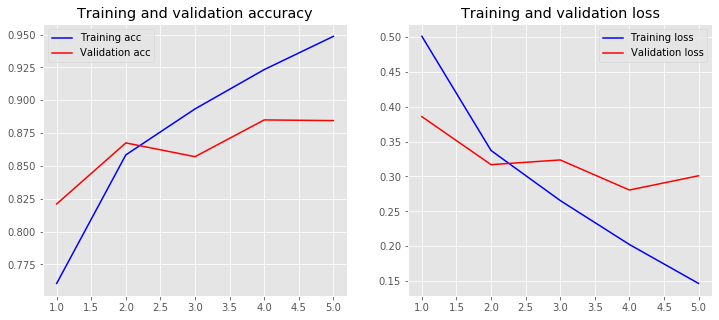

In [0]:
plot_history(history)